In [110]:
import numpy as np
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt

import math
from math import log

In [111]:
# Define LSTM Neural Networks
class LstmRNN(nn.Module):
    """
        Parameters:
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size=1, output_size=1, num_layers=1):
        super().__init__()
 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers) # utilize the LSTM model in torch.nn 
        self.forwardCalculation = nn.Linear(hidden_size, output_size)
 
    def forward(self, _x):
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s*b, h)
        x = self.forwardCalculation(x)
        x = x.view(s, b, -1)
        return x

# Define the normalization function
def minmaxscaler(x):
    minx = np.amin(x)
    maxx = np.amax(x)
    return (x - minx)/(maxx - minx), (minx, maxx)

def preminmaxscaler(x, minx, maxx):
    return (x - minx)/(maxx - minx)

def unminmaxscaler(x, minx, maxx):
    return x * (maxx - minx) + minx

In [114]:
filepath = 'data.csv'                                   # 此处设置文件路径
df = pd.read_csv(filepath, header=None)
df = np.array(df, dtype=np.float32)
df_length = len(df)
df_length

38

In [115]:
train_length = 26                                        # 此处设置训练集长度
valid_length = 8                                         # 此处设置验证集长度
test_length = df_length - train_length - valid_length    # 此处设置测试集长度

train_data = df[0:train_length]
valid_data = df[train_length:train_length+valid_length]
test_data = df[train_length+valid_length:]

train_data, train_minmax = minmaxscaler(train_data)
valid_data, valid_minmax = minmaxscaler(valid_data)
test_data, test_minmax = minmaxscaler(test_data)

#考虑到本人所用数据较小，因此将batch_size设置为1，若数据量较大，可将batch_size设置为较大的数值

train_tensor = train_data.reshape(-1, train_length, 1)   # 此处设置训练集输入维度，括号中间的数值为batch_size
valid_tensor = valid_data.reshape(-1, valid_length, 1)   # 此处设置验证集输入维度，括号中间的数值为batch_size
test_tensor = test_data.reshape(-1, test_length, 1)      # 此处设置测试集输入维度，括号中间的数值为batch_size

In [116]:
train_tensor = torch.from_numpy(train_tensor)
valid_tensor = torch.from_numpy(valid_tensor)
test_tensor = torch.from_numpy(test_tensor)

In [117]:
lstm_model = LstmRNN(1, 16, output_size=1, num_layers=1) # 16 hidden units
print('LSTM model:', lstm_model)
print('model.parameters:', lstm_model.parameters())

LSTM model: LstmRNN(
  (lstm): LSTM(1, 16)
  (forwardCalculation): Linear(in_features=16, out_features=1, bias=True)
)
model.parameters: <generator object Module.parameters at 0x0000022251ECC5F0>


In [118]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)

In [119]:
max_epochs = 1000
for epoch in range(max_epochs):
    output = lstm_model(train_tensor)
    loss = loss_function(output, train_tensor)
 
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
 
    if loss.item() < 1e-6:
        print('Epoch [{}/{}], Loss: {:.7f}'.format(epoch+1, max_epochs, loss.item()))
        print("The loss value is reached")
        break
    elif (epoch+1) % 100 == 0:
        print('Epoch: [{}/{}], Loss:{:.7f}'.format(epoch+1, max_epochs, loss.item()))

Epoch: [100/1000], Loss:0.0000321
Epoch: [200/1000], Loss:0.0000098
Epoch: [300/1000], Loss:0.0000078
Epoch: [400/1000], Loss:0.0000065
Epoch: [500/1000], Loss:0.0000058
Epoch: [600/1000], Loss:0.0000055
Epoch: [700/1000], Loss:0.0000053
Epoch: [800/1000], Loss:0.0000052
Epoch: [900/1000], Loss:0.0000052
Epoch: [1000/1000], Loss:0.0000051


In [120]:
# prediction on training dataset
predictive_for_training = lstm_model(train_tensor)
predictive_for_training = predictive_for_training.view(-1, 1).data.numpy()
torch.save(lstm_model.state_dict(), 'model_params.pkl')

In [121]:
# ----------------- valid -------------------
lstm_model.load_state_dict(torch.load('model_params.pkl'))
lstm_model = lstm_model.eval()

# prediction on validation dataset
predictive_for_validing = lstm_model(valid_tensor)
predictive_for_validing = predictive_for_validing.view(-1, 1).data.numpy()

In [122]:
# ----------------- test -------------------
lstm_model.load_state_dict(torch.load('model_params.pkl'))
lstm_model = lstm_model.eval()
# prediction on testing dataset
predictive_for_testing = lstm_model(test_tensor)
predictive_for_testing = predictive_for_testing.view(-1, 1).data.numpy()

In [123]:
# 反归一化

valid_data = unminmaxscaler(valid_data, valid_minmax[0], valid_minmax[1])
train_data = unminmaxscaler(train_data, train_minmax[0], train_minmax[1])
test_data = unminmaxscaler(test_data, test_minmax[0], test_minmax[1])
predictive_for_training = unminmaxscaler(predictive_for_training, train_minmax[0], train_minmax[1])
predictive_for_validing = unminmaxscaler(predictive_for_validing, valid_minmax[0], valid_minmax[1])
predictive_for_testing = unminmaxscaler(predictive_for_testing, test_minmax[0], test_minmax[1])

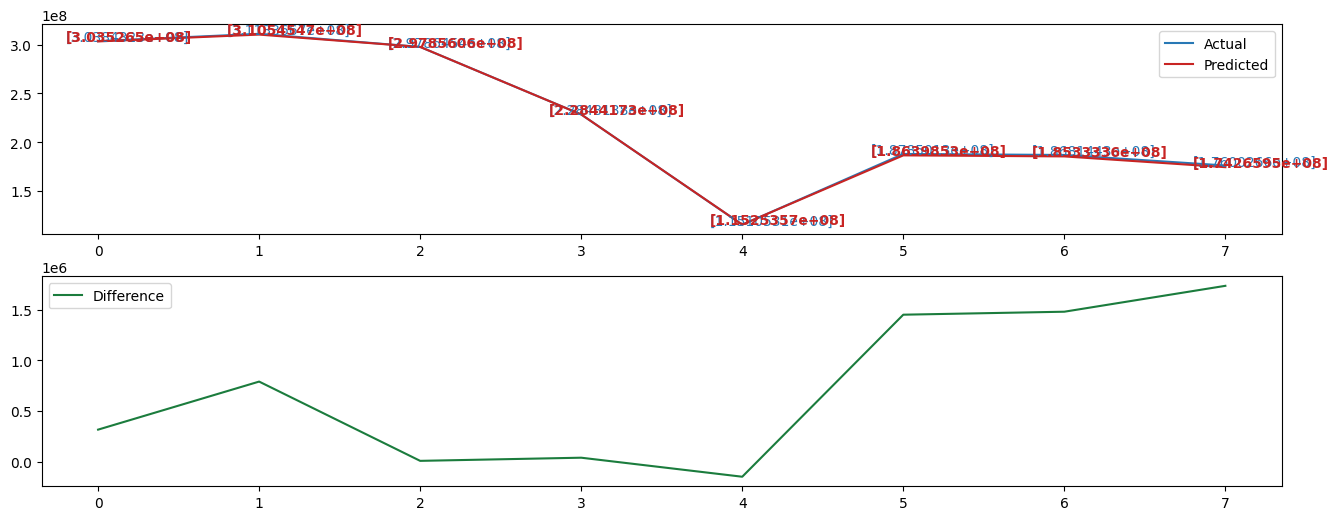

In [125]:
#对验证集预测结果进行可视化

fig, axs = plt.subplots(2, 1, figsize=(16, 6))

# plot the actual and predicted data
axs[0].plot(valid_data, color='#2878B5', label='Actual')
axs[0].plot(predictive_for_validing, color='#C82423', label='Predicted')
axs[0].legend(loc='best')

step = 1
for i in range(0, len(valid_data), step):
    offset = 1500
    axs[0].annotate(str(valid_data[i]), xy=(i, valid_data[i]), xytext=(i-0.2, valid_data[i]+offset),color='#2878B5')
    axs[0].annotate(str(predictive_for_validing[i]), xy=(i, predictive_for_validing[i]), xytext=(i-0.2, predictive_for_validing[i]-offset),color='#C82423', weight='bold')


# plot the difference between the actual and predicted data
axs[1].plot(valid_data - predictive_for_validing, color='#1b7c3d', label='Difference')
axs[1].legend(loc='best')

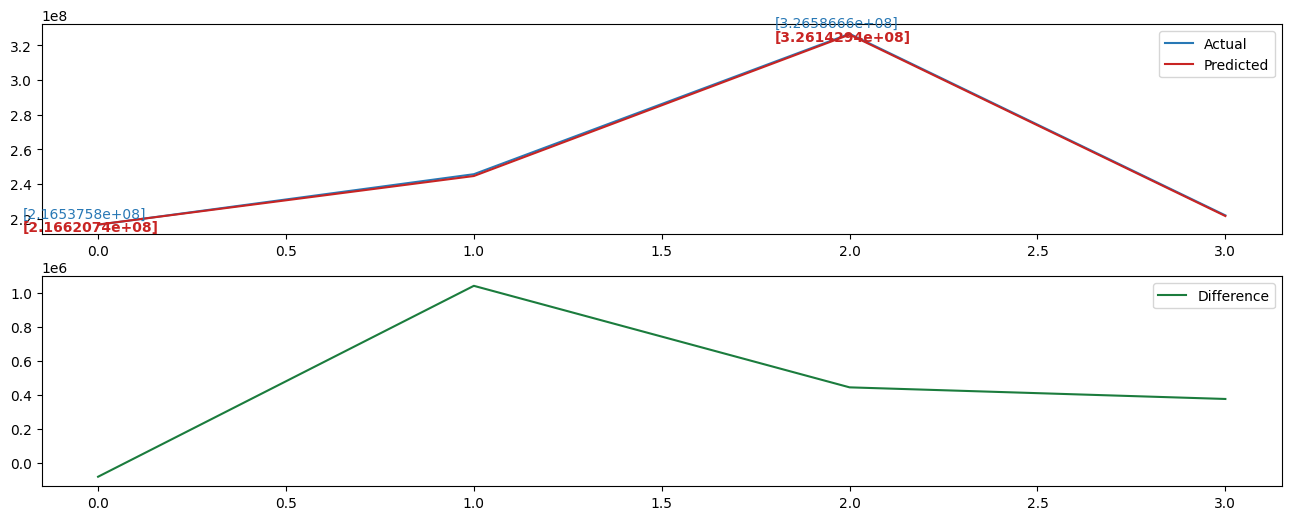

In [126]:
#对测试集预测结果进行可视化

fig, axs = plt.subplots(2, 1, figsize=(16, 6))

# plot the actual and predicted data
axs[0].plot(test_data, color='#2878B5', label='Actual')
axs[0].plot(predictive_for_testing, color='#C82423', label='Predicted')
axs[0].legend(loc='best')

step = 2
for i in range(0, len(test_data), step):
    offset = 4000000
    axs[0].annotate(str(test_data[i]), xy=(i, test_data[i]), xytext=(i-0.2, test_data[i]+offset),color='#2878B5')
    axs[0].annotate(str(predictive_for_testing[i]), xy=(i, predictive_for_testing[i]), xytext=(i-0.2, predictive_for_testing[i]-offset),color='#C82423', weight='bold')


# plot the difference between the actual and predicted data
axs[1].plot(test_data - predictive_for_testing, color='#1b7c3d', label='Difference')
axs[1].legend(loc='best')

In [127]:
rmse_valid = np.sqrt(np.mean((valid_data - predictive_for_validing)**2))
rmse_test = np.sqrt(np.mean((test_data - predictive_for_testing)**2))
print('RMSE on validation dataset: ', rmse_valid)
print('RMSE on testing dataset: ', rmse_test)

RMSE on validation dataset:  1004166.4
RMSE on testing dataset:  598083.44
